**7 Combining Different Models for Ensemble Learning**  
    **Goal**:
- Make predictions based on majority voting
- Use bagging to reduce overfitting by drawing random combinations of training dataset with repetition
- Apply boosting to build powerful models from weak learner that learn from their mistakes

# Learning with ensembles

*ensemble method* is about combining classifiers to predict rather than just one classifier. In this chapter, the focus is **majority voting**, which choose the most voted class (more than 50).

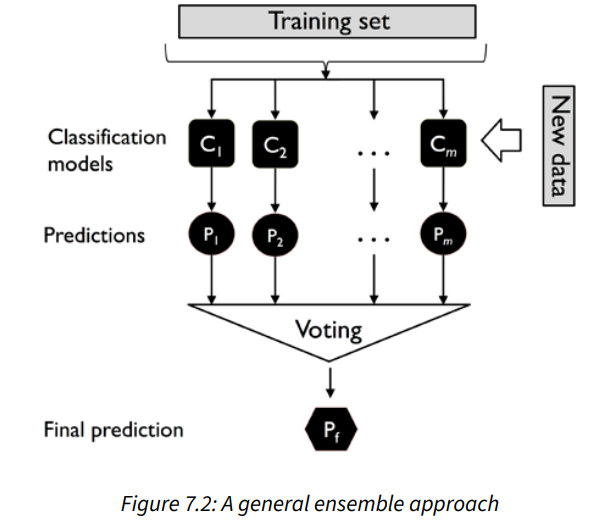

**Why classifiers make more accurate prediction more than one classifier?**. Make an assumption is that all the classifiers have the same error rate $\varepsilon$. So the probability of choosing wrong prediction is: 
$$P(y \geq k) = \sum_{k}^{n} \binom{n}{k} \, \varepsilon^k (1-\varepsilon)^{n-k}$$ 
Take a concrete example, a model has 11 classifiers, each classifier has $\epsilon = 0.25$, so
$$F(k) = \sum_{k=6}^{11} \binom{11}{k} \, \varepsilon^k (1 - \varepsilon)^{n-k} \approx 0.034$$
That's very very small compared to just one classifier

In [3]:
#implement CDF of ensemble error
from scipy.special import comb
import math
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error**k * 
    (1-error)**(n_classifier - k)
    for k in range(k_start, n_classifier + 1)]
    return sum(probs)
    

In [4]:
ensemble_error(n_classifier = 11, error = 0.25)

np.float64(0.03432750701904297)

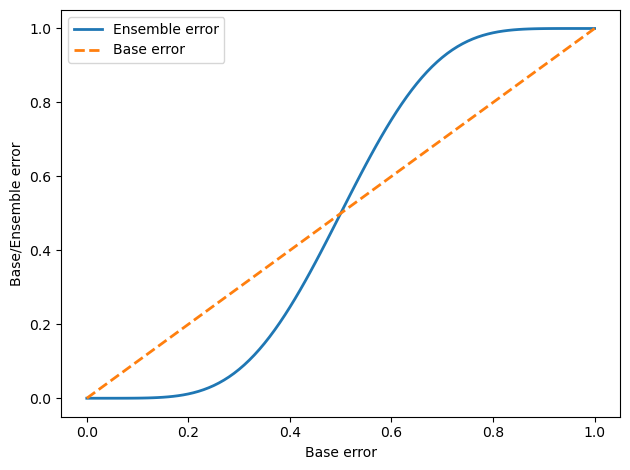

In [6]:
#draw graph for each value of e
import numpy as np
import matplotlib.pyplot as plt
error_range = np.arange(0.0, 1.01, 0.01)
ens_error = [ensemble_error(n_classifier = 11, error = error) for error in error_range]
plt.plot(error_range, ens_error, label = 'Ensemble error', linewidth = 2)
plt.plot(error_range, error_range, label = 'Base error', linestyle = '--', linewidth = 2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend()
plt.tight_layout()
plt.show()

# Combining classifiers via majority vote

## Implementing a simple mojority vote classifier

There's disadvantage in ensemble learning above, if model is highly non-linear, so linear model's result don't trust worthy, and maybe SVC is a more worthy classifier, so there's weighted version:
$$\hat{y} = \arg\max_{i} \sum_{j=1}^{m} w_j \chi_{A}(C_j(x) = i)$$ 
$\chi_{A}(C_j(x) = i)$ is indicator, it equal to 1 if $C_j(x) = i$ else 0

In [7]:
import numpy as np
np.argmax(np.bincount([0,0,1], weights = [0.2,0.2,0.6]))

np.int64(1)

The modified version of majority vote for predicting class using probability:
$$ \hat{y} = \arg\max_{i} \sum_{j=1}^{m} w_{j}p_{ij}$$

In [10]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])
p = np.average(ex, axis = 0, weights = [0.2, 0.2, 0.6])
print(p)
np.argmax(p)

[0.58 0.42]


np.int64(0)

In [11]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {
            key: value for key,
            value in _name_estimators(classifiers)
        }
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' "
                             f"or 'classlabel'"
                             f"; got (vote={self.vote})")
        if self.weights and \
                len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and'
                             f' weights must be equal'
                             f'; got {len(self.weights)} weights,'
                             f' {len(self.classifiers)} classifiers')

        # Use LabelEncoder to ensure class labels start
        # with 0, which is important for np.argmax
        # call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []

        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X,
                                        self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote
            # Collect results from clf.predict calls
            predictions = np.asarray([
                clf.predict(X) for clf in self.classifiers_
            ]).T

            maj_vote = np.apply_along_axis(
                lambda x: np.argmax(
                    np.bincount(x, weights=self.weights)
                ),
                axis=1, arr=predictions
            )
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0,
                               weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(
                        deep=True).items():
                    out[f'{name}__{key}'] = value
            return out


## Using the majority voting principle to make predictions

In [12]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, stratify = y, random_state = 1)

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np
clf1 = LogisticRegression(penalty = 'l2', 
                          C=0.001,
                          solver = 'lbfgs',
                          random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion = 'entropy',
                              random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric= 'minkowski')
pipe1=Pipeline([['sc', StandardScaler()],
                ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation: \n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator = clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')


10-fold cross validation: 

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [19]:
mv_clf = MajorityVoteClassifier(
    classifiers=[pipe1, clf2, pipe3]
)
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
          f'(+/- {scores.std():.2f}) [{label}]')


ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: nan (+/- nan) [Majority voting]


D:\ap\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\ap\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "D:\ap\Lib\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        pos_label=pos_label,
    )
  File "D:\ap\Lib\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ~~~~~~~~~~~~~~~~~~~~^
        estimator, *args, response_method=response_method, **kwargs
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "D:\ap\Lib\site-packages\sklearn\utils\_response.py", line 235, in _get_response_values
   